In [42]:
import ROOT
import numpy as np
import pandas as pd
from array import array

In [56]:
# DEFINING A FUNCTION THAT CLEANS THE DATA 
def CLEAN_INPUT(file):
    # cleaning superconductor data
    data = []
    clean_data = []

    # extract raw data
    f = open(file, 'r')
    for line in f:
        data.append(line)
    f.close()

    for i in range(0, len(data)):
        # broken apart by spaces
        temp = data[i].split(' ')
        if len(temp) == 3:
            clean_data.append(temp)
            # gets rid of newline in str
            clean_data[-1][-1] = clean_data[-1][-1].replace('\n','')

    # convert str to flt
    clean_data = np.array(clean_data, dtype = float)
    return clean_data

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD 
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# DEFINING A FUNCTION THAT CALCULATES THE RESISTANCE HAVING VOLTAGE AND CURRENT AS INPUTS 
calculate_R = lambda param : abs(param[0]/param[1]) # param = [V, I]


In [71]:
data = CLEAN_INPUT('cooling1.txt') # I (mA), Voltage (mV), Temperature (K)

df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']
df = df[(df['Resistance ($\Omega$)']<1.25e-2) | (df['Resistance ($\Omega$)']>1.49e-2)] # Adjusting vertical range to fit data

# ADDING UNCERTAINTIES ---------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df = df[(df['Temperature (K)'] > 120) & (df['Temperature (K)'] < 150)]
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
134,100.066080,1.632996,149.947957,0.016319,0.01,0.01,0.01,0.0001
135,100.062763,1.624918,148.827749,0.016239,0.01,0.01,0.01,0.0001
136,100.069784,1.613420,147.731630,0.016123,0.01,0.01,0.01,0.0001
137,100.067449,1.601756,146.663944,0.016007,0.01,0.01,0.01,0.0001
138,100.064927,1.590510,145.598323,0.015895,0.01,0.01,0.01,0.0001


In [127]:
# PLOTTING OUR DATA
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']


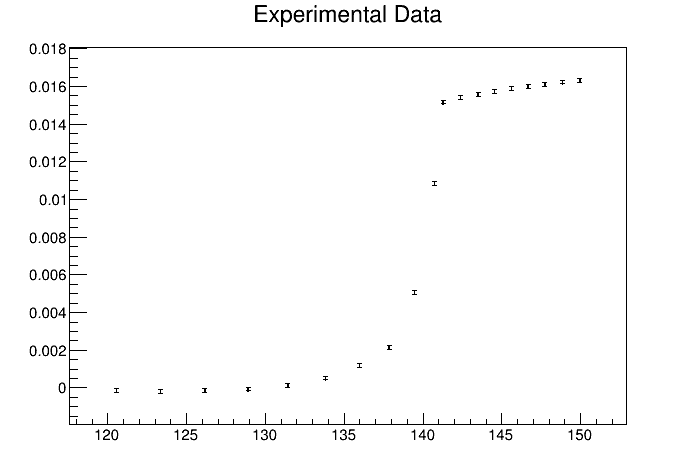

In [128]:
g = ROOT.TGraphErrors(len(xdata), array('d',xdata), array('d',ydata), array('d',error_x), array('d',error_y))
c4 = ROOT.TCanvas()
g.Draw('ap')
g.SetTitle('Experimental Data')
c4.Draw()

In [129]:
# DEFINING THE SIGMOID FUNCTION 
Sigmoid = lambda x, L ,x0, k : L/(1 + np.exp(-k*(x-x0))) 
# L: Height, k: steepness, x0: center

In [130]:
%%cpp
double sigmoid(double *x, double *par){
    return par[0]/(1 + TMath::Exp(-par[2]*(x[0]-par[1])));
}

In [131]:
fitFunc = ROOT.TF1("fitFunc", ROOT.sigmoid, xdata.min(), xdata.max(), npar=3)
fitFunc.SetParameters(0.01723423,140.092662,1.14455349) 
res = g.Fit(fitFunc, "S") 

 FCN=626.981 FROM MIGRAD    STATUS=CONVERGED      77 CALLS          78 TOTAL
                     EDM=2.12518e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.61054e-02   3.73598e-05   4.05327e-07   1.62889e+01
   2  p1           1.39946e+02   1.75051e-02   1.89596e-04   6.04496e-04
   3  p2           1.28982e+00   2.73616e-02   2.89318e-04  -3.94178e-03


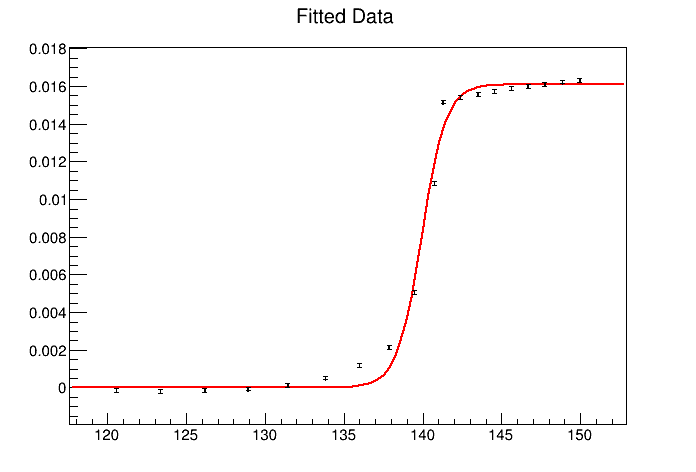

In [132]:
c2 = ROOT.TCanvas()
g.Draw('ap')
g.SetTitle('Fitted Data')
c2.Draw()

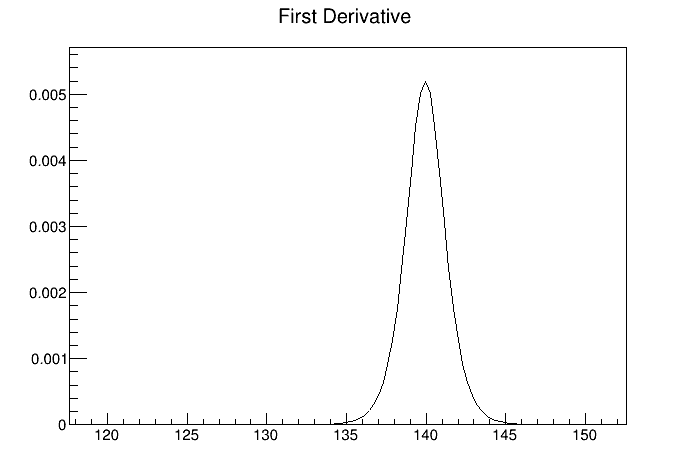

In [142]:
derivativeGraph = ROOT.TGraph()

num_points = 100
x_min = xdata.min()
x_max = xdata.max()
step = (x_max - x_min) / num_points
xdata2, ydata2 = [], []

for i in range(num_points):
    x = x_min + i * step
    xdata2.append(x)
    derivative_value = fitFunc.Derivative(x)
    ydata2.append(derivative_value)
    derivativeGraph.SetPoint(i, x, derivative_value)

c = ROOT.TCanvas()
derivativeGraph.Draw("AL")
derivativeGraph.SetTitle('First Derivative')
c.Draw()

In [146]:
xdata2[ydata2.index(max(ydata2))]

139.94576288000002